
# Exploring the SHAP library

In this example, we use the "Current Population Survey" dataset, already
used in the interpretation of linear models.

More info: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#linear_regression

In [1]:
import sklearn

sklearn.set_config(display="diagram")

In [2]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)
survey.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,5.10,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,4.95,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,6.67,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,4.00,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,7.50,35.0,White,Other,Other,Married



The aim is to predict the wage of a person based on set of features such as
age, experience, education, etc.

We will define a predictive model that uses a gradient-boosting as predictor.
Beforehand, the categorical data will be encoded using an
`OrdinalEncoder`. These categorical columns are
defined by the "category" data type reported by pandas.

In [3]:
survey.frame.dtypes

EDUCATION      float64
SOUTH         category
SEX           category
EXPERIENCE     float64
UNION         category
WAGE           float64
AGE            float64
RACE          category
OCCUPATION    category
SECTOR        category
MARR          category
dtype: object


We reproduce the same experiment setting than with the linear models example:
we will use a single train-test split.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    survey.data, survey.target, random_state=0
)


Let's first define the preprocessing pipeline for the encoding of categorical
features.

In [5]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer

categorical_columns = make_column_selector(dtype_include="category")
numerical_columns = make_column_selector(dtype_exclude="category")
preprocessor = make_column_transformer(
    (
        OrdinalEncoder(
            handle_unknown="use_encoded_value",
            unknown_value=-1,
        ),
        categorical_columns,
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)


Then, we define entire predictive model composed of the preprocessing and the
gradient-boosting regressor.

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

model = make_pipeline(
    preprocessor,
    HistGradientBoostingRegressor(max_iter=10_000, early_stopping=True, random_state=0),
)


Before to start, we will check the statistical performance of the model.
We can compare it with the linear models seen in the previous example.

In [7]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10f82f9d0>)],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(early_stopping=True,
                                               max_iter=10000,
                                               random_state=0))])

In [8]:
from sklearn.metrics import mean_absolute_error

print(
    f"MAE on the training set: "
    f"{mean_absolute_error(y_train, model.predict(X_train)):.3f} $/hour"
)
print(
    f"MAE on the training set: "
    f"{mean_absolute_error(y_test, model.predict(X_test)):.3f} $/hour"
)

MAE on the training set: 2.766 $/hour
MAE on the training set: 3.173 $/hour



Now, we use the SHAP library that allows to compute an approximation of the
Shapley values. However, before using SHAP, we need to preprocess the data
separately due to limited support of some scikit-learn components.

In [9]:
import pandas as pd

feature_names = categorical_columns(X_train) + numerical_columns(X_train)
X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train), columns=feature_names
)
X_test_preprocessed = pd.DataFrame(
    preprocessor.transform(X_test), columns=feature_names
)


Now, we use SHAP to get an approximation of the Shapley values for each
testing sample.

In [12]:
import shap

explainer = shap.Explainer(model[-1], masker=X_train_preprocessed, feature_perturbation="interventional")
shap_values = explainer(X_test_preprocessed)
shap_values.shape == X_test_preprocessed.shape

True


By inspecting `shap_values`, we observe that we get a feature attributions
for each data point of the testing set. We can as well see a repeated
information called `base_values`:

In [29]:
shap_values.values.shape, X_test_preprocessed.shape

((134, 10), (134, 10))

In [33]:
shap_values.base_values

array([8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499

In [30]:
shap_values

.values =
array([[ 3.68830636e-02, -2.32239500e-01, -1.06854189e-01, ...,
         2.59483073e+00, -3.90028974e-01, -7.35071822e-01],
       [ 4.76373676e-02, -4.63187559e-01, -1.04417039e-01, ...,
         2.04771438e+00, -1.63129992e-01,  7.62426802e-02],
       [ 4.09769317e-02, -1.44152806e+00, -4.17727128e-02, ...,
         2.31623070e+00,  1.65637028e-01,  6.34586953e-01],
       ...,
       [ 2.56250283e-02,  1.00016888e+00, -1.62747233e-01, ...,
         1.94000444e+00, -1.51455720e-01, -7.83374892e-02],
       [ 1.28496558e-02,  1.30988836e+00, -9.11441273e-02, ...,
         3.02476011e+00,  2.64137131e-04,  1.32200137e+00],
       [-2.95069948e-02,  6.28941027e-01, -7.79988068e-02, ...,
         2.53809250e+00, -1.43584640e-01, -8.14355114e-02]])

.base_values =
array([8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.46499123, 8.46499123, 8.46499123, 8.46499123, 8.46499123,
       8.4649912


Indeed, this base value represents the mean prediction and SHAP is
attributing feature values to explain the difference of each prediction
of the testing set in regards with the base value.

Let's show the SHAP values decomposition for the first sample of the test
set. Our model would produce the following value:

In [36]:
model.predict(X_test.iloc[[0]])

array([10.62950974])


The reported SHAP values for the different features are:

In [37]:
pd.Series(shap_values[0].values, index=feature_names)

SOUTH         0.036883
SEX          -0.232240
UNION        -0.106854
RACE         -0.347246
OCCUPATION    1.110654
SECTOR        0.091262
MARR          0.142329
EDUCATION     2.594831
EXPERIENCE   -0.390029
AGE          -0.735072
dtype: float64


Taking into account the base value, then the model prediction corresponds to
the following sum:

In [42]:
# model_output - model base = sum of shap values
# sum of shap values + model base = model output
shap_values[0].values.sum() + shap_values.base_values[0]

10.629509728002756


SHAP package comes with handy plotting facilities to visualize the Shapley
values. Let's start by the `waterfall` plot.

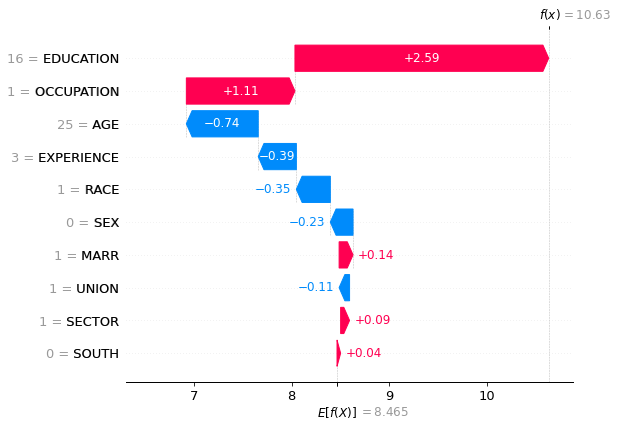

In [39]:
shap.plots.waterfall(shap_values[0])


It represents the graphical summation of the Shapley values for each
feature to observe the difference between the expected value and the actual
prediction. Another inline representation is the `force` plot.

In [43]:
shap.initjs()
shap.plots.force(
    shap_values.base_values[0],
    shap_values.values[0],
    feature_names=feature_names,
)


We can plot the Shapley values for all samples and encode the color of the
features values.

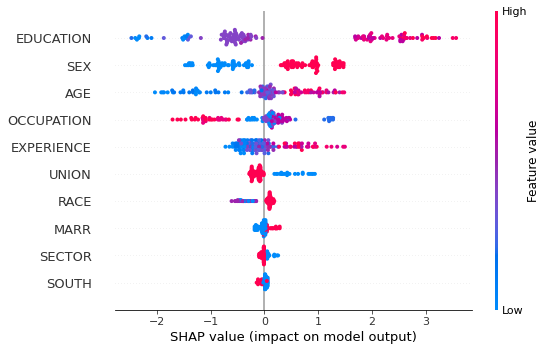

In [44]:
shap.plots.beeswarm(shap_values)


By combining the SHAP values for all samples of the testing set, we can then
get a global explanation.

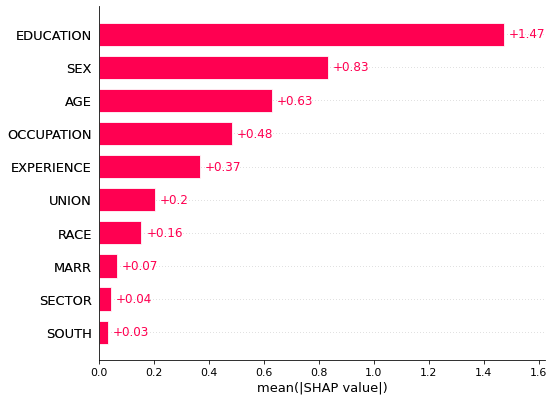

In [45]:
shap.plots.bar(shap_values)


Now, we can make a quick comparison between the Shapley values and the
permutation importances. For both, we will make a study of uncertainty by
using multiple permutations.

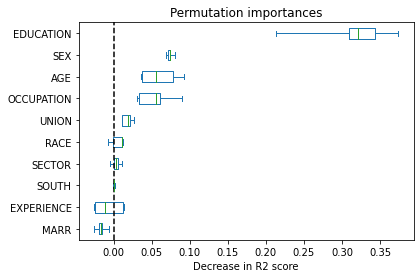

In [46]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

importances = permutation_importance(model, X_test, y_test, n_jobs=-1)
sorted_idx = importances.importances_mean.argsort()

importances = pd.DataFrame(
    importances.importances[sorted_idx].T, columns=X_test.columns[sorted_idx]
)
importances.plot.box(vert=False, whis=100)
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Decrease in R2 score")
_ = plt.title("Permutation importances")

We can make use of bootstrap resampling of the test set in order to repeat
the experiment with a variation of the test dataset.
https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
https://en.wikipedia.org/wiki/Sampling_(statistics)#Replacement_of_selected_units

In [56]:
import numpy as np

rng = np.random.default_rng(42)
n_bootstrap = 25

all_shap_values = []
for _ in range(n_bootstrap):
    bootstrap_idx = rng.choice(
        np.arange(X_test.shape[0]), size=X_test.shape[0], replace=True
    )
    X_test_bootstrap = X_test.iloc[bootstrap_idx]
    X_test_preprocessed = pd.DataFrame(
        preprocessor.transform(X_test_bootstrap), columns=feature_names
    )
    all_shap_values.append(explainer(X_test_preprocessed))

In [57]:
shap_values = pd.DataFrame(
    [np.abs(shap_values.values).mean(axis=0) for shap_values in all_shap_values],
    columns=feature_names,
)
sorted_idx = shap_values.mean().sort_values().index

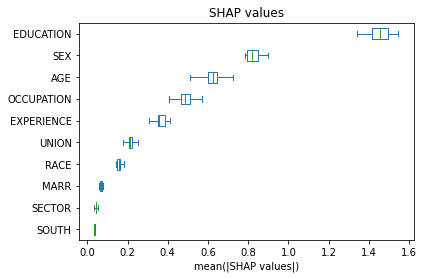

In [58]:
shap_values[sorted_idx].plot.box(vert=False, whis=10)
plt.xlabel("mean(|SHAP values|)")
_ = plt.title("SHAP values")


Comparing the permutation importance and the SHAP values, we observe a
difference in the ranking of the features.

## Bonus point regarding some SHAP internal:

In [59]:
explainer

In [60]:
explainer.feature_perturbation

'interventional'

In [61]:
explainer = shap.Explainer(model[-1])
explainer(X_test_preprocessed)

.values =
array([[ 0.03775363, -0.21230118, -0.08797472, ...,  2.24366849,
        -0.4012502 , -0.7910651 ],
       [-0.0223795 ,  0.66787461,  0.33046896, ..., -2.63470956,
         0.56320859,  0.57145219],
       [ 0.00922883,  1.27006904, -0.08175088, ...,  2.63846438,
         0.04563406,  1.35221942],
       ...,
       [ 0.03123623,  0.26388559, -0.09486064, ...,  1.60219343,
        -0.50755624, -1.49588722],
       [ 0.02636568,  0.95558204, -0.07900511, ...,  3.14498573,
        -0.08111348,  1.06779505],
       [ 0.03845897, -0.50506082, -0.11998626, ...,  1.58327975,
        -0.30667079,  0.03830304]])

.base_values =
array([[8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
    

In [62]:
explainer.feature_perturbation

'tree_path_dependent'

In [63]:
explainer = shap.Explainer(model[-1], feature_perturbation="interventional")
explainer(X_test_preprocessed)

.values =
array([[ 0.03775363, -0.21230118, -0.08797472, ...,  2.24366849,
        -0.4012502 , -0.7910651 ],
       [-0.0223795 ,  0.66787461,  0.33046896, ..., -2.63470956,
         0.56320859,  0.57145219],
       [ 0.00922883,  1.27006904, -0.08175088, ...,  2.63846438,
         0.04563406,  1.35221942],
       ...,
       [ 0.03123623,  0.26388559, -0.09486064, ...,  1.60219343,
        -0.50755624, -1.49588722],
       [ 0.02636568,  0.95558204, -0.07900511, ...,  3.14498573,
        -0.08111348,  1.06779505],
       [ 0.03845897, -0.50506082, -0.11998626, ...,  1.58327975,
        -0.30667079,  0.03830304]])

.base_values =
array([[8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
       [8.81363889],
    

In [64]:
explainer.feature_perturbation

'tree_path_dependent'

In [65]:
X = np.concatenate([
    [[0, 0]] * 400,
    [[0, 1]] * 100,
    [[1, 0]] * 100,
    [[1, 1]] * 400
], axis=0)
X

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [1, 1],
       [1, 1],
       [1, 1]])

In [66]:
y = np.array(
    [0] * 400 + [50] * 100 + [50] * 100 + [100] * 400
)

In [67]:
from sklearn.tree import DecisionTreeRegressor

tree_1 = DecisionTreeRegressor(random_state=0).fit(X, y)

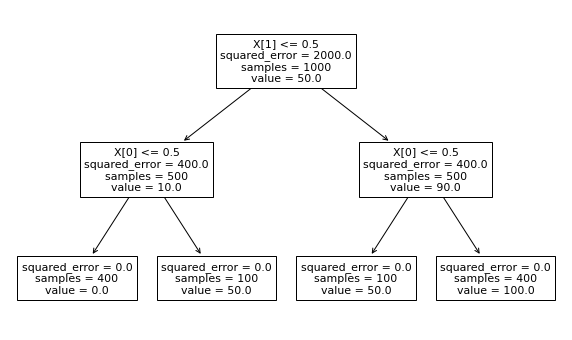

In [68]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 6))
_ = plot_tree(tree_1)

In [69]:
tree_2 = DecisionTreeRegressor(random_state=4).fit(X, y)

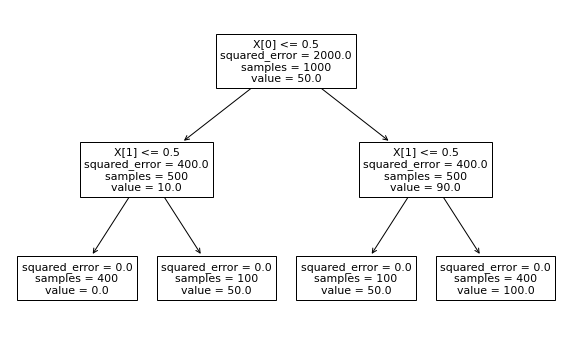

In [70]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 6))
_ = plot_tree(tree_2)

In [71]:
X_test = np.array([[1, 1]])
explainer = shap.explainers.Exact(tree_1.predict, X)
explainer(X_test)

.values =
array([[22. , 22.5]])

.base_values =
array([55.5])

.data =
array([[1, 1]])

In [72]:
explainer = shap.explainers.Exact(
    tree_1.predict, masker=shap.maskers.Independent(X, max_samples=X.shape[0])
)
explainer(X_test)

.values =
array([[25., 25.]])

.base_values =
array([50.])

.data =
array([[1, 1]])

In [73]:
explainer = shap.explainers.Exact(
    tree_2.predict, masker=shap.maskers.Independent(X, max_samples=X.shape[0])
)
explainer(X_test)

.values =
array([[25., 25.]])

.base_values =
array([50.])

.data =
array([[1, 1]])

In [74]:
explainer = shap.Explainer(tree_1)
explainer(X_test)

.values =
array([[17.5, 32.5]])

.base_values =
array([[50.]])

.data =
array([[1, 1]])

In [75]:
explainer = shap.Explainer(tree_2)
explainer(X_test)

.values =
array([[32.5, 17.5]])

.base_values =
array([[50.]])

.data =
array([[1, 1]])

In [76]:
explainer

In [77]:
explainer = shap.Explainer(tree_1, shap.maskers.Independent(X, max_samples=X.shape[0]))
explainer(X_test)

.values =
array([[25., 25.]])

.base_values =
array([50.])

.data =
array([[1, 1]])

In [78]:
explainer = shap.Explainer(tree_2, shap.maskers.Independent(X, max_samples=X.shape[0]))
explainer(X_test)

.values =
array([[25., 25.]])

.base_values =
array([50.])

.data =
array([[1, 1]])

In [79]:
explainer